In this lab you will do the following steps in order:

1. Load a new dataset using ``torchvision dataloader``
2. Perform transfer learning of a pre-trained NN (Neural Network)





Useful resources:

* [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)






Use GPU if available

In [1]:
import torch
import glob  # Import library for finding all files matching a pattern
from PIL import Image  # Import library for image processing
import numpy as np  # Import library for numerical operations (not used here)
import os  # Import library for operating system functionalities
from tqdm import tqdm  # Import library for displaying progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Data preparation

In [2]:
# #download images
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
# #download metadata
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
# #extract
# !tar -xf imdb_crop.tar
# !tar -xf imdb_meta.tar

In [3]:
# # move to data folder
# !mv imdb/ data/
# !mv imdb_crop/ data/

Remove grayscale images

In [4]:
# # Define a path pattern to search for all jpg images within subdirectories of "data/imdb_crop"
# image_path_pattern = "data/imdb_crop/*/*.jpg"

# # Find all image file paths matching the pattern
# image_paths = glob.glob(image_path_pattern)

# imgs_removed = 0
# # Iterate through each image path
# for image_path in tqdm(image_paths):
#   # Open the image using Pillow's Image class
#   image = Image.open(image_path)

#   # Get the number of color channels in the image (e.g., RGB has 3 channels)
#   num_channels = len(image.getbands())

#   # Check if the image has a different number of channels than expected (likely grayscale or unsupported format)
#   if num_channels != 3:
#     # If not 3 channels, remove the image file
#     os.remove(image_path)
#     # print(f"Removed {image_path} (not RGB format)")  # Print statement to show removed files
#     imgs_removed += 1

# print(f"Removed {imgs_removed} images") ### --> Removed 22532 images

Define function to convert numeric date to common date format

In [5]:
from datetime import datetime, timedelta  # Import libraries for date and time manipulation

def datenum_to_datetime(datenum):
  """
  Converts a date represented as a floating-point number (Excel-style) to a Python datetime object.

  Args:
      datenum (float): The date represented as a floating-point number.

  Returns:
      datetime: The converted datetime object (year only if conversion fails).
          If conversion fails due to ValueError, TypeError, or OverflowError,
          returns np.nan.
  """

  try:
    # Extract components from the datenum
    days = datenum % 1  # Extract days (decimal part)
    hours = days % 1 * 24  # Extract hours from remaining decimal part
    minutes = hours % 1 * 60  # Extract minutes from remaining decimal part
    seconds = minutes % 1 * 60  # Extract seconds from remaining decimal part

    # Convert to datetime object with separate day, hour, minute, and second components
    exact_date = (datetime.fromordinal(int(datenum))  # Convert integer part to date
                 + timedelta(days=int(days))  # Add extracted days
                 + timedelta(hours=int(hours))  # Add extracted hours
                 + timedelta(minutes=int(minutes))  # Add extracted minutes
                 + timedelta(seconds=round(seconds)))  # Add extracted seconds (rounded)

    # Adjust for Excel's epoch being different from standard epoch (correct for year)
    exact_date -= timedelta(days=366)

    # Return the year from the converted datetime object
    return exact_date.year

  except (ValueError, TypeError, OverflowError) as e:
    return np.nan  # Return np.nan if conversion fails


Define the [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy
import torch
import collections

class FacesDataset(Dataset):
      """Face Landmarks dataset.

      This class loads and preprocesses a dataset of face images with corresponding ages.
      It supports train, validation, and test splits.
      """

      def __init__(self, root_dir, transform, split):
        """
        Args:
            root_dir (string): Directory containing the images.
            transform (callable, optional): Transformation to be applied to the images.
            split (string): Split type ("train", "val", or "test").
        """
        self.split=split
        self.root_dir = root_dir
        self.data = self.get_data()  # Load and preprocess data
        total_data_len = int(len(self.data) * 0.5)  # Select small portion of the dataset

        # Randomly shuffle indices for train/val/test split
        idx = np.arange(total_data_len)
        np.random.seed(0)
        np.random.shuffle(idx)
        print(f"Shuffled indices (first 5): {idx[:5]}")  # Print first 5 shuffled indices

        # Select data based on split
        if split == "train":
            self.data = self.data[idx[:int(total_data_len * 0.6)]]
            print(split, ' indexes ', idx[:int(total_data_len * 0.6)])
        elif split == "val":
            self.data = self.data[idx[int(total_data_len * 0.6):int(total_data_len * 0.8)]]
            print(split, ' indexes ', idx[int(total_data_len * 0.6):int(total_data_len * 0.8)])
        else:
            self.data = self.data[idx[int(total_data_len * 0.8):]]
            print(split, ' indexes ', idx[int(total_data_len * 0.8):])

        # Analyze age distribution (uncomment to print)
        # age_distribution = collections.Counter()
        # for i, sample in enumerate(self.data):
        #     age_distribution[sample[1]] += 1
        # print(age_distribution)  # Uncomment to print the Counter object


        self.transform = transform



      def get_data(self):
        """
        Loads and preprocesses data from the IMDB dataset (.MAT file).

        This function performs the following steps:
            1. Loads data from the MAT file using scipy.io.loadmat.
            2. Defines column names for the loaded data.
            3. Converts the loaded data into a dictionary.
            4. Creates a pandas DataFrame for efficient data manipulation.
            5. Prints DataFrame shape and the first few rows (before processing).
            6. Converts date of birth to age using vectorized operations.
            7. Filters images based on face score and presence of a single face.
                - Removes images without a face (face_score != -np.inf).
                - Ensures only one face is present (second_face_score.isna()).
                - Filters based on minimum face score threshold (face_score >= 3.5).
                - Filters for valid age range (0 <= age <= 100).
                - Converts age to integer and drops unnecessary columns.
            8. Constructs full image paths by prepending the root directory.
            9. Filters for images with existing paths using vectorized boolean indexing.
            10. Prints DataFrame shape and the first few rows (after processing).
            11. Returns the preprocessed data as a NumPy array.
        """

        # Load data from MAT file and define column names
        mat_imdb = scipy.io.loadmat('data/imdb/imdb.mat')
        columns = ["full_path", "dob", "photo_taken", "second_face_score", "face_score"]

        # Convert loaded data into a dictionary
        data_dict = {col: mat_imdb['imdb'][0][0][col][0] for col in columns}

        # Create pandas DataFrame for efficient data manipulation
        df_imdb = pd.DataFrame(data_dict)
        if self.split=="train":
          print("Before processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows 

        # Convert date of birth to age using vectorized operations
        df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)
        df_imdb['age'] = df_imdb['photo_taken'].sub(df_imdb['date_of_birth'])  # Handle potential NaNs

        # Filter images based on face score and presence of a single face
        df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]  # Remove images without a face
        df_imdb = df_imdb[df_imdb['second_face_score'].isna()]  # Ensure only one face is present
        df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]  # Filter based on minimum face score threshold
        df_imdb = df_imdb[(df_imdb['age'] <= 100) & (df_imdb['age'] >= 0)]  # Filter for valid age range
        df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))  # Convert age to integer
        df_imdb = df_imdb.drop(columns=['date_of_birth', 'dob', 'photo_taken', "second_face_score", "face_score"])  # Remove unnecessary columns

        print(self.root_dir)
        # Construct full image paths using vectorized operations
        df_imdb['full_path'] = self.root_dir+"/"+ df_imdb['full_path'].apply(lambda x: x[0])

        # Filter for images with existing paths using vectorized boolean indexing
        df_imdb = df_imdb[df_imdb['full_path'].apply(os.path.exists)]

        if self.split=="train":
          print("After processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        return df_imdb.to_numpy()  # Return preprocessed data as a NumPy array

      def __len__(self):
        """
        Returns the length of the dataset (number of samples).

        This method overrides the default behavior of `len` for the dataset object.
        It simply returns the length of the internal `data` list, which represents
        the preprocessed data after loading and filtering.
        """
        return len(self.data)

      def __getitem__(self, idx):
        """
        Retrieves a sample (image and corresponding age) at a given index.

        This method overrides the default behavior of indexing for the dataset object.
        It takes an index `idx` and performs the following:
            1. Accesses the image name and age at the specified index from `self.data`.
            2. Opens the image using `Image.open` with the full path constructed by
               combining `self.root_dir` and `img_name`.
            3. Applies the defined transformation (`self.transform`) to the image.
            4. Normalizes the age by dividing by 100.
            5. Creates a dictionary `sample` containing the preprocessed image (`image`)
               and the normalized age as a PyTorch tensor (`torch.tensor(age).float()`).
            6. Returns the constructed `sample` dictionary.
        """
        img_name, age = self.data[idx]
        # image = Image.open(os.path.join(self.root_dir, img_name))
        image = Image.open(os.path.join(img_name))
        image = self.transform(image)
        age = age / 100

        sample = {'image': image, 'age': torch.tensor(age).float()}
        return sample

Build the train/val/test dataloaders




In [7]:
import pickle

# Define data transformations (augmentations for training and normalization)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 64

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("data/imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("data/imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("data/imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")


Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
data/imdb_crop
After processing:
(71828, 2)
                                            full_path  age
7   data/imdb_crop/02/nm0000002_rm1363385088_1924-...   80
15  data/imdb_crop/02/nm0000002_rm2585828096_1924-...   82
18  data/imdb_crop/02/nm0000002_rm2769394176_1924-...   82
19  data/imdb_crop/02/n

In [8]:
!pwd
!ls
!ls data/
!ls data/imdb/

/home/andrea/unimib/Supervised/00_exercises/lab_06


data					models		 net_last_e3.pth
imdb_crop.tar				net_last_e0.pth  net_last_e4.pth
imdb_meta.tar				net_last_e1.pth  net_last_e5.pth
lab_06_CNN_transfer_learning_all.ipynb	net_last_e2.pth  net_last_e6.pth
imdb  imdb_crop
imdb.mat


2. Define a Neural Network (NN) [Mobilenet](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2) pretrained on Imagenet.

Replace the last classifier

In [21]:
import torchvision
import torch.nn as nn

# Define the model architecture (MobileNetV2)
net = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')  # Load pre-trained weights
net_name = net.__class__.__name__  # Get the name of the network class

# Adjust the final classification layer
num_ftrs = net.classifier[1].in_features  # Get the number of input features for the last layer
net.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
    nn.GELU(),  # GELU activation function
    nn.Linear(512, 32),  # Second linear layer with 32 units
    nn.GELU(),  # GELU activation function
    nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
)

# Move the model to the appropriate device (CPU or GPU)
net.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [22]:
from torchsummary import summary
# Print model summary
summary(net, (3, 256, 256))  # Input shape (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

**Transfer learning**

Train only the last layers

In [23]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters

Unfreezing layer: classifier, Parameter shape: torch.Size([512, 1280])
Unfreezing layer: classifier, Parameter shape: torch.Size([512])
Unfreezing layer: classifier, Parameter shape: torch.Size([32, 512])
Unfreezing layer: classifier, Parameter shape: torch.Size([32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1, 32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1])


Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [24]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 10  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler


**Fine-tuning**

Train the network on the training data performing a validation at the end of each epoch. The evaluation is done using [PLCC](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [SROCC](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

1, [33, 337] loss: 0.0801	PLCC: 0.600	SROCC: 0.533	lr: 0.000971
1, [66, 337] loss: 0.0819	PLCC: 0.602	SROCC: 0.559	lr: 0.000965
1, [99, 337] loss: 0.0778	PLCC: 0.642	SROCC: 0.587	lr: 0.000960
1, [132, 337] loss: 0.0795	PLCC: 0.608	SROCC: 0.550	lr: 0.000953
1, [165, 337] loss: 0.0812	PLCC: 0.582	SROCC: 0.540	lr: 0.000947
1, [198, 337] loss: 0.0807	PLCC: 0.621	SROCC: 0.582	lr: 0.000940
1, [231, 337] loss: 0.0775	PLCC: 0.649	SROCC: 0.598	lr: 0.000932
1, [264, 337] loss: 0.0791	PLCC: 0.653	SROCC: 0.587	lr: 0.000924
1, [297, 337] loss: 0.0815	PLCC: 0.591	SROCC: 0.546	lr: 0.000916
1, [330, 337] loss: 0.0805	PLCC: 0.576	SROCC: 0.537	lr: 0.000907
Validation loss: 0.088396	PLCC: 0.642	SROCC: 0.597


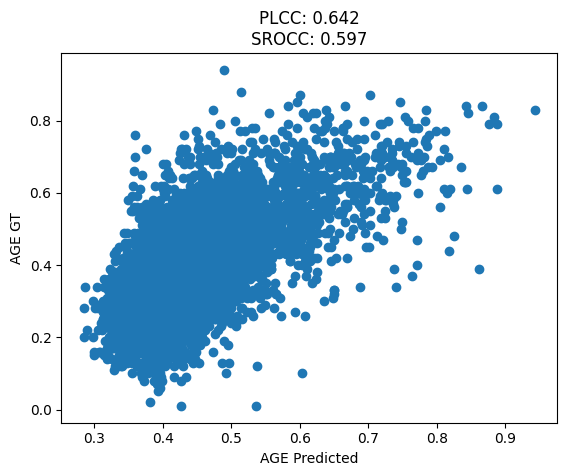

2, [33, 337] loss: 0.0796	PLCC: 0.616	SROCC: 0.538	lr: 0.000896
2, [66, 337] loss: 0.0794	PLCC: 0.611	SROCC: 0.557	lr: 0.000887
2, [99, 337] loss: 0.0744	PLCC: 0.631	SROCC: 0.577	lr: 0.000877
2, [132, 337] loss: 0.0788	PLCC: 0.622	SROCC: 0.578	lr: 0.000867
2, [165, 337] loss: 0.0781	PLCC: 0.639	SROCC: 0.580	lr: 0.000856
2, [198, 337] loss: 0.0791	PLCC: 0.639	SROCC: 0.592	lr: 0.000845
2, [231, 337] loss: 0.0816	PLCC: 0.618	SROCC: 0.561	lr: 0.000834
2, [264, 337] loss: 0.0834	PLCC: 0.587	SROCC: 0.542	lr: 0.000823
2, [297, 337] loss: 0.0782	PLCC: 0.637	SROCC: 0.603	lr: 0.000811
2, [330, 337] loss: 0.0765	PLCC: 0.665	SROCC: 0.606	lr: 0.000799
Validation loss: 0.074897	PLCC: 0.650	SROCC: 0.599


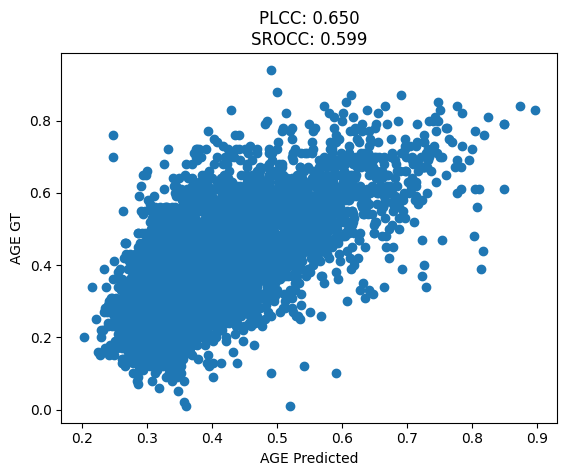

3, [33, 337] loss: 0.0767	PLCC: 0.652	SROCC: 0.586	lr: 0.000783
3, [66, 337] loss: 0.0769	PLCC: 0.643	SROCC: 0.588	lr: 0.000771
3, [99, 337] loss: 0.0777	PLCC: 0.644	SROCC: 0.594	lr: 0.000758
3, [132, 337] loss: 0.0745	PLCC: 0.649	SROCC: 0.600	lr: 0.000745
3, [165, 337] loss: 0.0766	PLCC: 0.646	SROCC: 0.611	lr: 0.000731
3, [198, 337] loss: 0.0769	PLCC: 0.642	SROCC: 0.601	lr: 0.000718
3, [231, 337] loss: 0.0766	PLCC: 0.661	SROCC: 0.625	lr: 0.000704
3, [264, 337] loss: 0.0778	PLCC: 0.656	SROCC: 0.608	lr: 0.000690
3, [297, 337] loss: 0.0772	PLCC: 0.638	SROCC: 0.594	lr: 0.000675
3, [330, 337] loss: 0.0747	PLCC: 0.672	SROCC: 0.622	lr: 0.000661
Validation loss: 0.078675	PLCC: 0.661	SROCC: 0.612


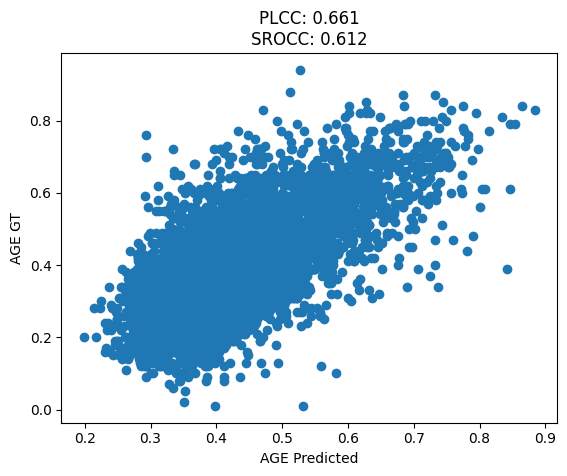

4, [33, 337] loss: 0.0742	PLCC: 0.694	SROCC: 0.640	lr: 0.000643
4, [66, 337] loss: 0.0744	PLCC: 0.678	SROCC: 0.621	lr: 0.000629
4, [99, 337] loss: 0.0753	PLCC: 0.644	SROCC: 0.607	lr: 0.000614
4, [132, 337] loss: 0.0721	PLCC: 0.668	SROCC: 0.641	lr: 0.000599
4, [165, 337] loss: 0.0752	PLCC: 0.650	SROCC: 0.598	lr: 0.000584
4, [198, 337] loss: 0.0753	PLCC: 0.668	SROCC: 0.625	lr: 0.000569
4, [231, 337] loss: 0.0740	PLCC: 0.691	SROCC: 0.639	lr: 0.000554
4, [264, 337] loss: 0.0749	PLCC: 0.673	SROCC: 0.620	lr: 0.000539
4, [297, 337] loss: 0.0766	PLCC: 0.652	SROCC: 0.602	lr: 0.000523
4, [330, 337] loss: 0.0767	PLCC: 0.647	SROCC: 0.603	lr: 0.000508
Validation loss: 0.072880	PLCC: 0.668	SROCC: 0.621


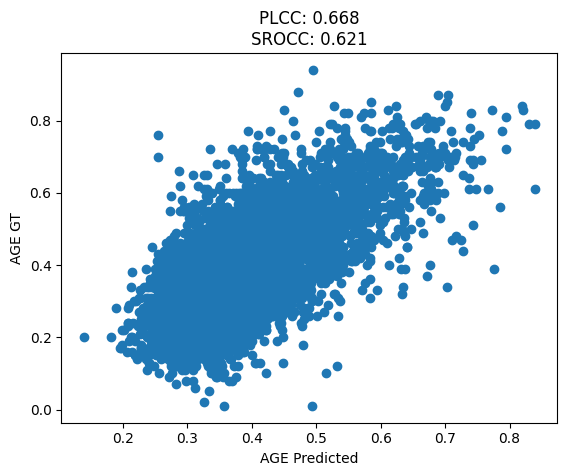

5, [33, 337] loss: 0.0714	PLCC: 0.709	SROCC: 0.651	lr: 0.000490
5, [66, 337] loss: 0.0724	PLCC: 0.691	SROCC: 0.647	lr: 0.000475
5, [99, 337] loss: 0.0736	PLCC: 0.683	SROCC: 0.617	lr: 0.000459
5, [132, 337] loss: 0.0732	PLCC: 0.685	SROCC: 0.654	lr: 0.000444
5, [165, 337] loss: 0.0733	PLCC: 0.687	SROCC: 0.652	lr: 0.000429
5, [198, 337] loss: 0.0744	PLCC: 0.672	SROCC: 0.626	lr: 0.000414
5, [231, 337] loss: 0.0737	PLCC: 0.669	SROCC: 0.640	lr: 0.000399
5, [264, 337] loss: 0.0721	PLCC: 0.683	SROCC: 0.630	lr: 0.000384
5, [297, 337] loss: 0.0748	PLCC: 0.650	SROCC: 0.605	lr: 0.000370
5, [330, 337] loss: 0.0740	PLCC: 0.681	SROCC: 0.638	lr: 0.000355
Validation loss: 0.073617	PLCC: 0.670	SROCC: 0.624


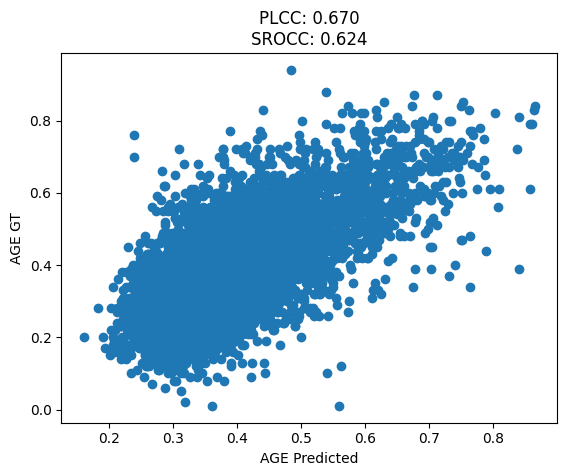

6, [33, 337] loss: 0.0725	PLCC: 0.684	SROCC: 0.651	lr: 0.000338
6, [66, 337] loss: 0.0726	PLCC: 0.684	SROCC: 0.640	lr: 0.000323
6, [99, 337] loss: 0.0712	PLCC: 0.695	SROCC: 0.655	lr: 0.000309
6, [132, 337] loss: 0.0715	PLCC: 0.708	SROCC: 0.656	lr: 0.000295
6, [165, 337] loss: 0.0697	PLCC: 0.715	SROCC: 0.664	lr: 0.000282
6, [198, 337] loss: 0.0728	PLCC: 0.697	SROCC: 0.655	lr: 0.000268
6, [231, 337] loss: 0.0703	PLCC: 0.698	SROCC: 0.679	lr: 0.000255
6, [264, 337] loss: 0.0697	PLCC: 0.691	SROCC: 0.672	lr: 0.000242
6, [297, 337] loss: 0.0732	PLCC: 0.687	SROCC: 0.635	lr: 0.000229
6, [330, 337] loss: 0.0691	PLCC: 0.731	SROCC: 0.679	lr: 0.000217
Validation loss: 0.071853	PLCC: 0.678	SROCC: 0.633


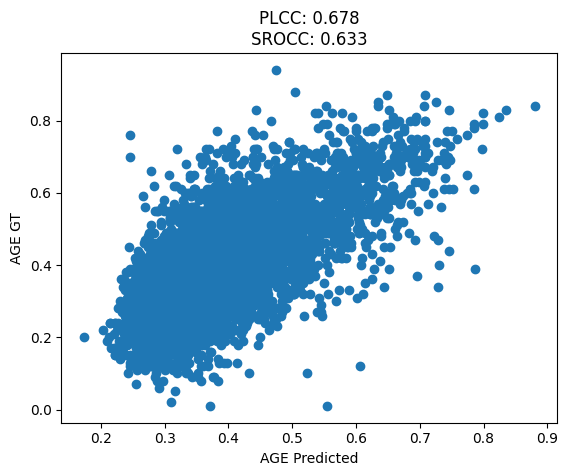

7, [33, 337] loss: 0.0714	PLCC: 0.712	SROCC: 0.672	lr: 0.000202
7, [66, 337] loss: 0.0702	PLCC: 0.706	SROCC: 0.663	lr: 0.000190
7, [99, 337] loss: 0.0711	PLCC: 0.689	SROCC: 0.652	lr: 0.000178
7, [132, 337] loss: 0.0694	PLCC: 0.712	SROCC: 0.662	lr: 0.000167
7, [165, 337] loss: 0.0684	PLCC: 0.714	SROCC: 0.677	lr: 0.000156
7, [198, 337] loss: 0.0700	PLCC: 0.710	SROCC: 0.679	lr: 0.000145
7, [231, 337] loss: 0.0701	PLCC: 0.716	SROCC: 0.673	lr: 0.000135
7, [264, 337] loss: 0.0713	PLCC: 0.717	SROCC: 0.678	lr: 0.000125
7, [297, 337] loss: 0.0676	PLCC: 0.716	SROCC: 0.676	lr: 0.000116
7, [330, 337] loss: 0.0701	PLCC: 0.701	SROCC: 0.655	lr: 0.000106
Validation loss: 0.071699	PLCC: 0.682	SROCC: 0.637


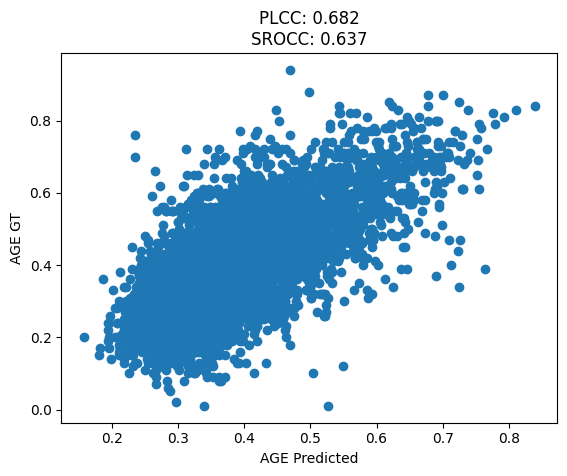

8, [33, 337] loss: 0.0707	PLCC: 0.732	SROCC: 0.693	lr: 0.000096
8, [66, 337] loss: 0.0693	PLCC: 0.718	SROCC: 0.684	lr: 0.000087
8, [99, 337] loss: 0.0675	PLCC: 0.716	SROCC: 0.680	lr: 0.000079
8, [132, 337] loss: 0.0691	PLCC: 0.711	SROCC: 0.665	lr: 0.000072
8, [165, 337] loss: 0.0671	PLCC: 0.739	SROCC: 0.702	lr: 0.000065
8, [198, 337] loss: 0.0675	PLCC: 0.737	SROCC: 0.687	lr: 0.000058
8, [231, 337] loss: 0.0698	PLCC: 0.709	SROCC: 0.678	lr: 0.000052
8, [264, 337] loss: 0.0682	PLCC: 0.724	SROCC: 0.677	lr: 0.000046
8, [297, 337] loss: 0.0686	PLCC: 0.714	SROCC: 0.682	lr: 0.000040
8, [330, 337] loss: 0.0676	PLCC: 0.721	SROCC: 0.701	lr: 0.000035
Validation loss: 0.071431	PLCC: 0.682	SROCC: 0.637


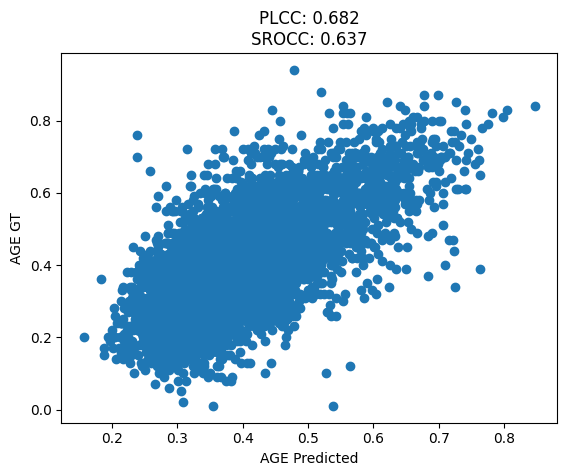

9, [33, 337] loss: 0.0701	PLCC: 0.748	SROCC: 0.704	lr: 0.000030
9, [66, 337] loss: 0.0661	PLCC: 0.723	SROCC: 0.684	lr: 0.000026
9, [99, 337] loss: 0.0663	PLCC: 0.720	SROCC: 0.695	lr: 0.000022
9, [132, 337] loss: 0.0662	PLCC: 0.731	SROCC: 0.695	lr: 0.000019
9, [165, 337] loss: 0.0681	PLCC: 0.744	SROCC: 0.706	lr: 0.000016
9, [198, 337] loss: 0.0674	PLCC: 0.727	SROCC: 0.689	lr: 0.000014
9, [231, 337] loss: 0.0687	PLCC: 0.709	SROCC: 0.675	lr: 0.000012
9, [264, 337] loss: 0.0662	PLCC: 0.735	SROCC: 0.702	lr: 0.000011
9, [297, 337] loss: 0.0683	PLCC: 0.725	SROCC: 0.688	lr: 0.000010
9, [330, 337] loss: 0.0689	PLCC: 0.718	SROCC: 0.694	lr: 0.000010
Validation loss: 0.071637	PLCC: 0.682	SROCC: 0.636


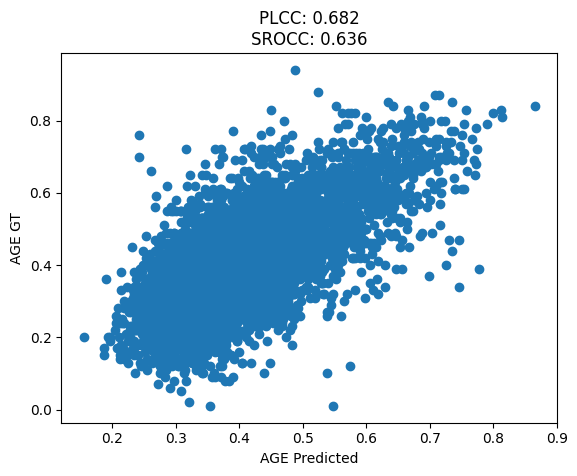

10, [33, 337] loss: 0.0659	PLCC: 0.737	SROCC: 0.704	lr: 0.000010
10, [66, 337] loss: 0.0662	PLCC: 0.744	SROCC: 0.710	lr: 0.000011
10, [99, 337] loss: 0.0666	PLCC: 0.744	SROCC: 0.706	lr: 0.000012
10, [132, 337] loss: 0.0695	PLCC: 0.699	SROCC: 0.652	lr: 0.000014
10, [165, 337] loss: 0.0677	PLCC: 0.720	SROCC: 0.687	lr: 0.000016
10, [198, 337] loss: 0.0662	PLCC: 0.743	SROCC: 0.694	lr: 0.000018
10, [231, 337] loss: 0.0676	PLCC: 0.729	SROCC: 0.691	lr: 0.000021
10, [264, 337] loss: 0.0678	PLCC: 0.732	SROCC: 0.705	lr: 0.000025
10, [297, 337] loss: 0.0658	PLCC: 0.738	SROCC: 0.697	lr: 0.000029
10, [330, 337] loss: 0.0685	PLCC: 0.724	SROCC: 0.703	lr: 0.000033
Validation loss: 0.071534	PLCC: 0.682	SROCC: 0.638


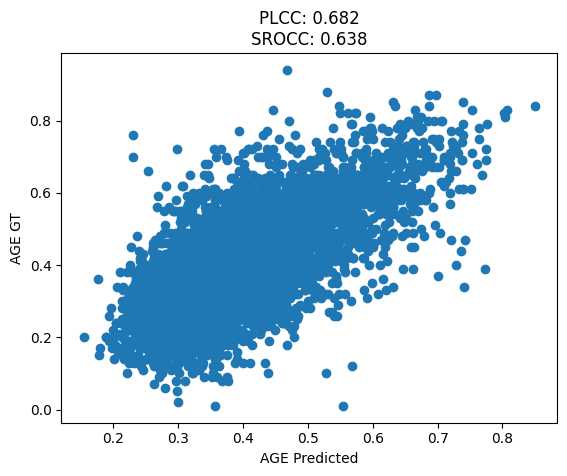

Finished Training


In [26]:

# Training loop
for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    plt.show()

    # Save the model (optional)
    torch.save(net.state_dict(), f"models/{net_name}_last_epoch_{epoch}.pth")  # Save model state after each epoch

print('Finished Training')


Evaluate on the test-set

Test loss: 0.073301	PLCC: 0.686	SROCC: 0.627


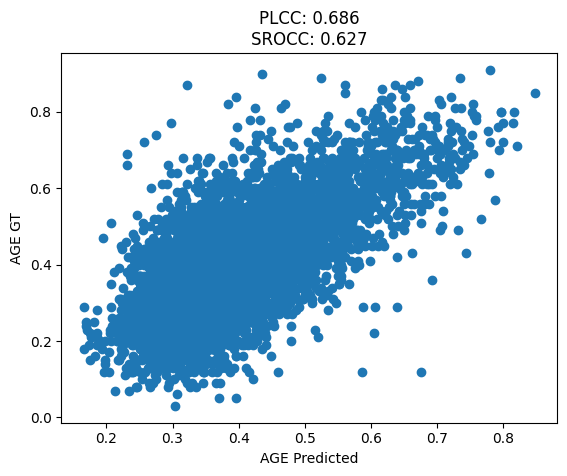

In [27]:
# Testing loop (after training)
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels (predicted age)
pr_labels = []  # List to store predicted labels (model output)

net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

for i, data in enumerate(testloader):
    # Get inputs and labels from the data loader
    inputs, labels = data["image"], data["age"]
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = net(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
    loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
    running_loss.append(loss.item())

# Calculate and print test performance metrics
gt_labels = np.stack(gt_labels)  # Combine ground truth labels
pr_labels = np.stack(pr_labels)  # Combine predictions
s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

# Visualization (optional)
plt.scatter(pr_labels, gt_labels)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
plt.show()


**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).
2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html#classification) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.